# Jacobienne et Hessienne

La méthode `jax.grad` s'applique exclusivement aux fonctions à valeurs scalaires.

Ce qui correspond bien à l'usage courant en deep learning. On dérive la loss par rapport aux paramètres $\theta$. Le résultat $d\theta$ a la même shape que $\theta$:


Par exemple supposons que $\theta$ soit un vecteur:
$$
d\theta= (d\theta_i) \ \text{ avec pour chaque $i$: } d\theta_i= \frac{∂f}{∂\theta_i} (\theta)
$$

Et si maintenant $\theta$ soit est une matrice:
$$
d\theta= (d\theta_{ij}) \ \text{ avec pour chaque $ij$: } d\theta_i= \frac{∂f}{∂\theta_{ij}} (\theta)
$$

### Jacobienne

Si on veut dériver des fonctions à valeurs vectorielle, il faut utiliser la jacobienne: Supposons par exemple que $\theta$ est un vecteur et que $f(\theta)$ est aussi un vecteur. Alors

$$
J =(J_{ij})  \ \text{ avec pour chaque $i,j$: } J_{ij}= \frac{∂f_i}{∂\theta_j} (\theta)
$$
Attention à l'ordre des indices. Le premier est celui qui correspond à la dimension de l'espace d'arriver.

In [2]:
import jax.numpy as jnp
import jax

Exemple avec une fonction de $\mathbb R^5$ dans $\mathbb R^{10}$:

In [3]:
def f(𝜃):
    return jnp.concat([𝜃,𝜃**2])

𝜃=jnp.ones([5])

f(𝜃).shape

In [4]:
J=jax.jacfwd(f)(𝜃)
J.shape

Exemple avec une fonction de $\mathbb R^{5\times 2}$ dans $\mathbb R^{10}$:

In [5]:
def f(𝜃):
    return jnp.concat([𝜃[:,0],𝜃[:,1]**2])

𝜃=jnp.ones([5,2])

f(𝜃).shape

In [6]:
J=jax.jacfwd(f)(𝜃)
J.shape

***A vous:*** De manière générale: Si $f$ prend en entrée un argument de shape `s1` et qu'il ressort un argument de shape `s2`. Quelle est la shape de la Jacobienne ?

## Dérivation forward.

* `jacfwd` signifie jacobienne-forward.
* `jacrev` signifie jacobienne-reverse.

La seconde correspond au mode de calcul des gradients: on effectue une backpropagation sur chaque sortie de la fonction.

La première correspond à une dérivation forward.

## Forward

 $y = h(g(f(x)))$. Nous voulons $\frac{dy}{dx}$

On veut propager le calcul de la source vers la cible. On utilise les nombres duaux.

### Introduction aux Nombres Duaux

Un nombre dual $a + b\epsilon$ est une extension des nombres réels où $\epsilon$ est un nombre infinitésimal non nul tel que $\epsilon^2 = 0$. Les règles d'arithmétique avec les nombres duaux sont les suivantes :

* $(a + b\epsilon) + (c + d\epsilon) = (a + c) + (b + d)\epsilon$
* $(a + b\epsilon)(c + d\epsilon) = ac + ad\epsilon + bc\epsilon + bd\epsilon^2 = ac + (ad + bc)\epsilon$ (puisque $\epsilon^2 = 0$)

La propriété clé
$$
f(x + 1\epsilon) = f(x) + f'(x)\epsilon
$$



### Application à la Fonction Composée $y = h(g(f(x)))$


1.  **Évaluation de $f(x)$ avec un nombre dual :**
    Entrons $x_0 + 1\epsilon$ dans la fonction $f$:
    $$
    f(x_0 + 1\epsilon) = f(x_0) + f'(x_0)\epsilon
    $$
    Notons
    * $u_0 = f(x_0)$ et $u_1 = f'(x_0)$.
    
    Le résultat est donc $u_0 + u_1\epsilon$.


2.  **Évaluation de $g(u)$:**
    Maintenant, entrons $u_0 + u_1\epsilon$ dans la fonction $g$:
    $$
    g(u_0 + u_1\epsilon) = g(u_0) + g'(u_0)(u_1\epsilon) = g(u_0) + g'(f(x_0))f'(x_0)\epsilon
    $$
    Notons
    * $v_0 = g(u_0) = g(f(x_0))$
    * $v_1 = g'(u_0)u_1 = g'(f(x_0))f'(x_0)$.

    Le résultat est donc $v_0 + v_1\epsilon$.

3.  **Évaluation de $h(v)$:**
    Enfin, entrons $v_0 + v_1\epsilon$ dans la fonction $h$:
    $$
    h(v_0 + v_1\epsilon) = h(v_0) + h'(v_0)(v_1\epsilon) = h(g(f(x_0))) + h'(g(f(x_0)))g'(f(x_0))f'(x_0)\epsilon
    $$
    Notons
    * $y_0 = h(v_0) = h(g(f(x_0)))$
    * $y_1 = h'(v_0)v_1 = h'(g(f(x_0)))g'(f(x_0))f'(x_0)$.
    

Par identification, le coefficient de $\epsilon$ dans le résultat final est la dérivée recherchée.





### En résumé

* Nous propageons une perturbation initiale (représentée par le coefficient de $\epsilon$) à travers chaque étape de la composition de la fonction.
* À chaque étape, la perturbation est transformée par la dérivée de la fonction interne.
* Le coefficient de $\epsilon$ dans le résultat final donne directement la dérivée de la fonction composée au point d'évaluation.

Pour une fonction avec une seule entrée, la dérivation forward avec les nombres duaux permet de calculer la valeur de la fonction et sa dérivée en une seule passe. C'est une méthode efficace pour la dérivation automatique dans ce cas.

### Plusieurs variables indépendances.


Pour calculer les dérivées partielles de $f(x,y)$ en $x_0$ et $y_0$ on fait 2 passages:  
* on fixe $y_0$ et on calcule $f(x_0,y_0+ 1 \epsilon )$
* on fixe $x_0$ et on calcule $f(x_01 \epsilon,y_0 )$

### Diagramme en diamant

Considérons une fonction de la forme $g(f_1(x), f_2(x))$


1.  **Propager la perturbation à travers les fonctions internes ($f_1$ et $f_2$) :**
    *  $f_1(x_0 + 1\epsilon)= f_1(x_0) + f_1'(x_0)\epsilon$.
    *  $f_2(x_0 + 1\epsilon)=f_2(x_0) + f_2'(x_0)\epsilon$.

2.  **Évaluer la fonction externe $g$ avec les résultats duaux :**
    
    $$g(f_1(x_0 + 1\epsilon), f_2(x_0 + 1\epsilon)) = g(f_1(x_0) + f_1'(x_0)\epsilon, f_2(x_0) + f_2'(x_0)\epsilon)$$

3.  **Utiliser les règles d'arithmétique des nombres duaux pour développer l'expression :**
    (similaire à un développement de Taylor)
    $$g(u_0 + u_1\epsilon, v_0 + v_1\epsilon) \approx g(u_0, v_0) + \frac{\partial g}{\partial u}(u_0, v_0) u_1\epsilon + \frac{\partial g}{\partial v}(u_0, v_0) v_1\epsilon$$
    On a déjà calculer toutes les valeurs:
    * $u_0 = f_1(x_0)$
    * $u_1 = f_1'(x_0)$
    * $v_0 = f_2(x_0)$
    * $v_1 = f_2'(x_0)$.

4.  **Identifitication finale:**
    $$
    g(f_1(x_0 + 1\epsilon), f_2(x_0 + 1\epsilon)) = y_0 + y_1\epsilon
    $$
    Le terme $y_1$ c'est la dérivée qu'on cherche. D'après l'étape précédente, on a :
    $$y_1 = \frac{\partial g}{\partial u}(f_1(x_0), f_2(x_0)) f_1'(x_0) + \frac{\partial g}{\partial v}(f_1(x_0), f_2(x_0)) f_2'(x_0)$$


On comprend ainsi qu'il faut utiliser:
* La dérivation forward quand la dimension d'entrée est plus petite que la dimension de sortie
* La dérivation reverse quand la dimension d'entrée est plus grande que la dimension de sortie (en particulier quand on dispose d'une fonction à valeur scalaire, telle une loss).

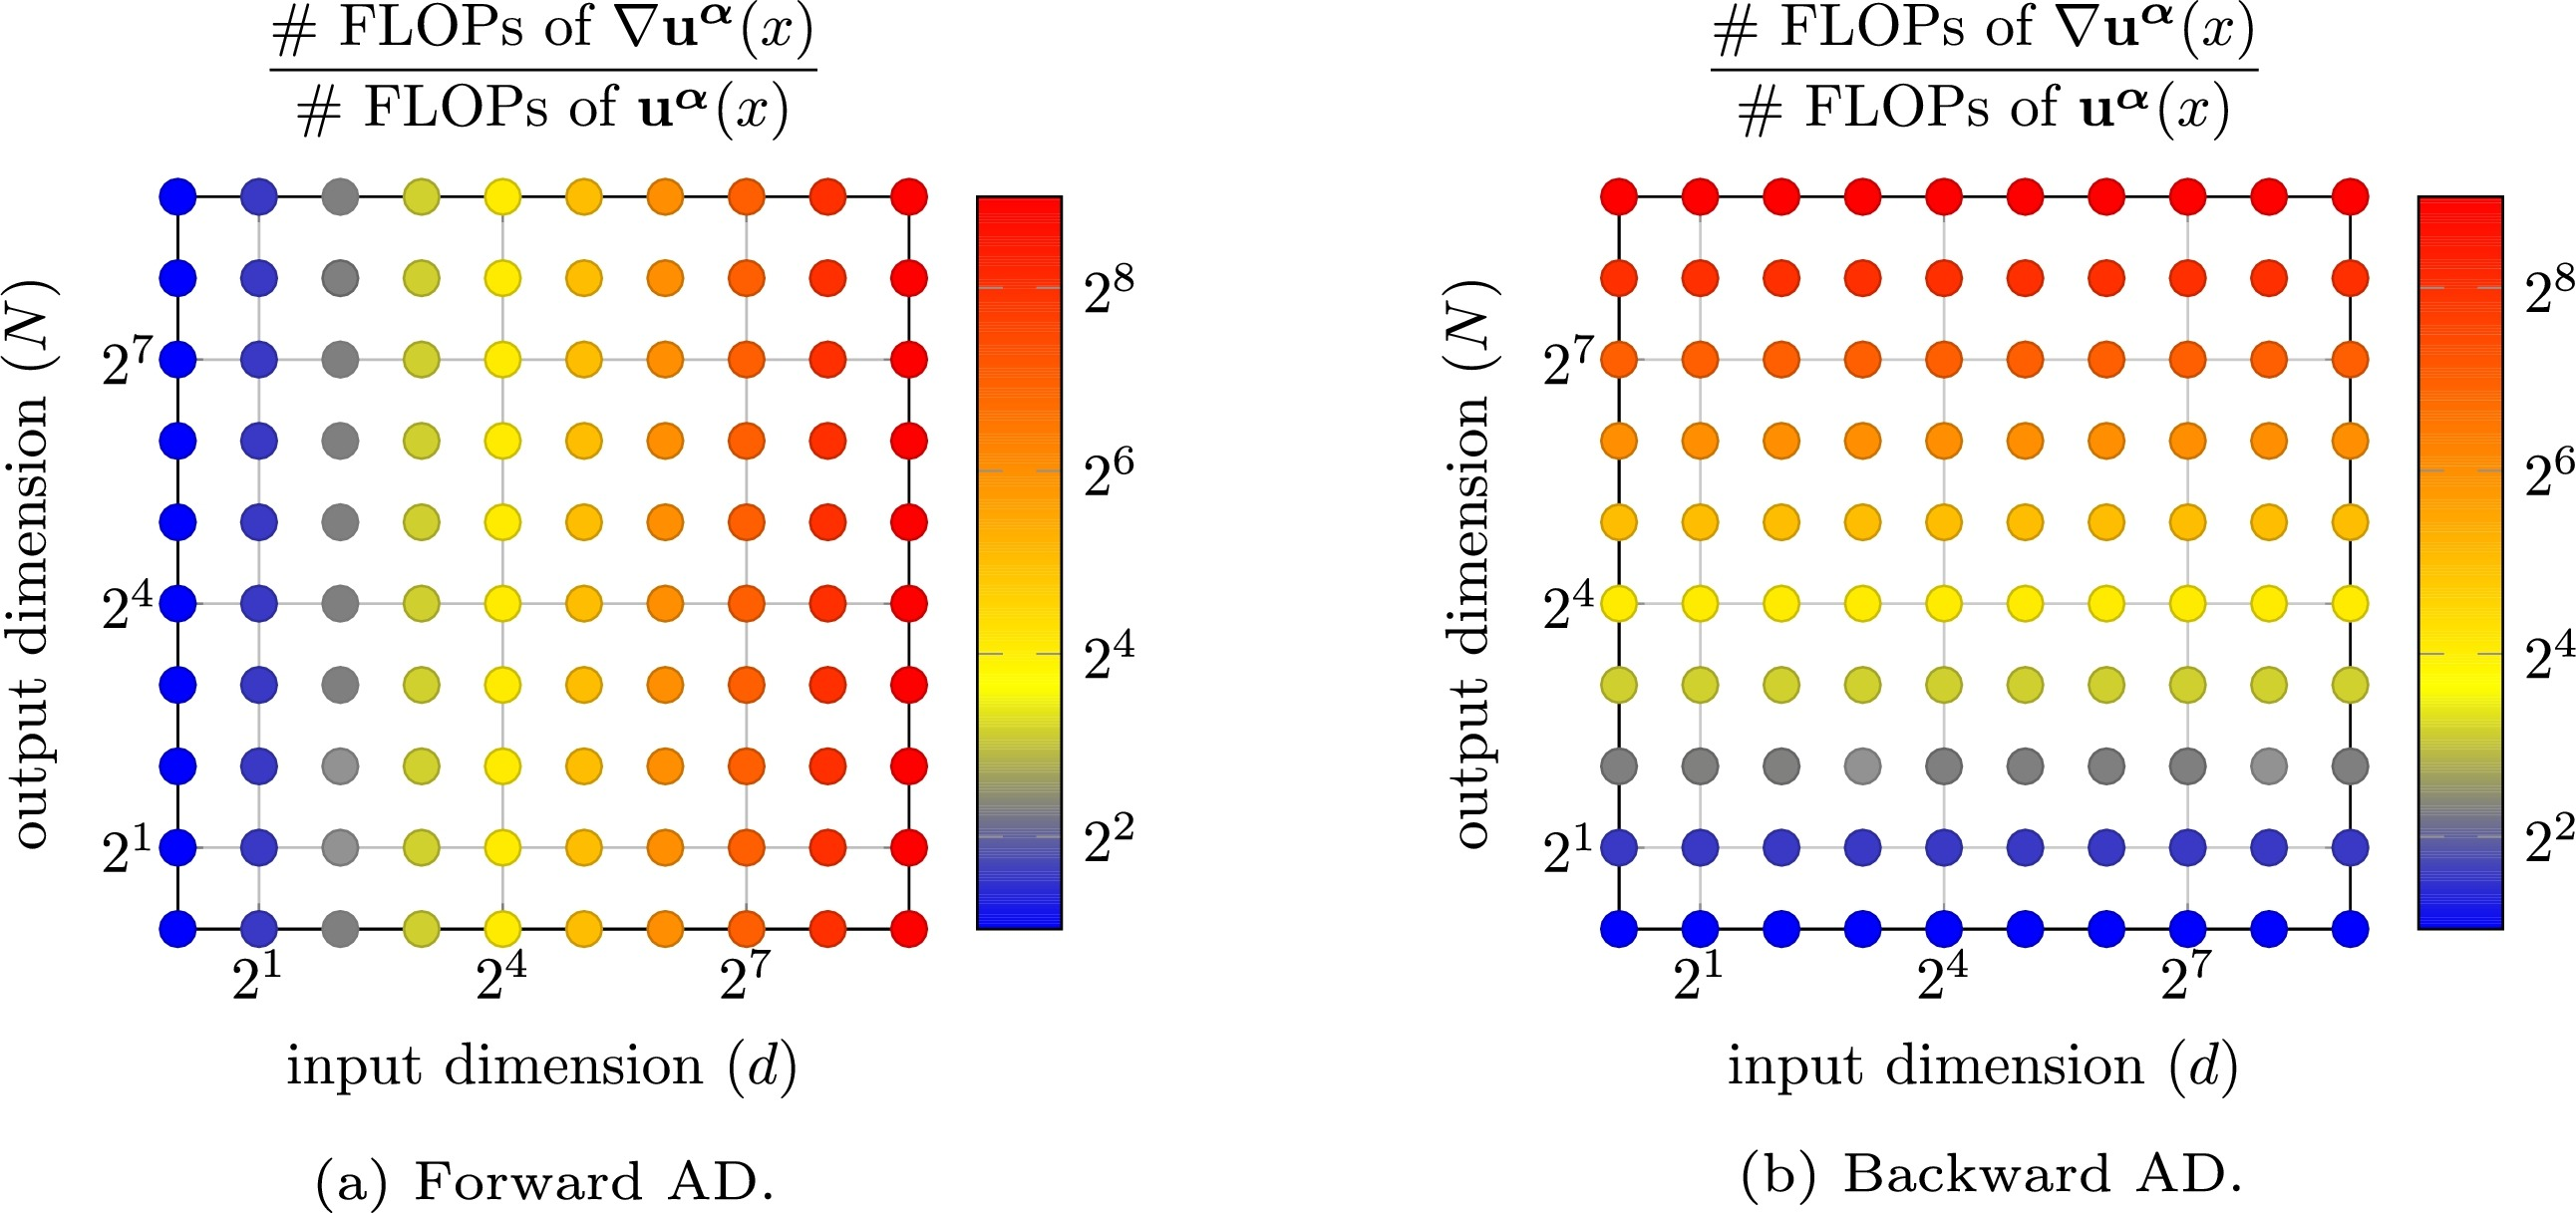

## Le défi prog.

In [7]:
def curl(F):
    """
    Calculates the curl of a 3D vector field F using JAX.

    Args:
        F: A JAX function representing the vector field.
           It should take a single argument (a 3D vector)
           and return a 3D vector.

    Returns:
        A JAX function that computes the curl of F at a given point.
    """
    def curl_F(x):
        # Calculate partial derivatives of each component of F
        Fx, Fy, Fz = lambda p: F(p)[0], lambda p: F(p)[1], lambda p: F(p)[2]

        dFz_dy = jax.grad(Fz, argnums=0)(x)[1]
        dFy_dz = jax.grad(Fy, argnums=0)(x)[2]

        dFx_dz = jax.grad(Fx, argnums=0)(x)[2]
        dFz_dx = jax.grad(Fz, argnums=0)(x)[0]

        dFy_dx = jax.grad(Fy, argnums=0)(x)[0]
        dFx_dy = jax.grad(Fx, argnums=0)(x)[1]

        # Compute the components of the curl
        curl_x = dFz_dy - dFy_dz
        curl_y = dFx_dz - dFz_dx
        curl_z = dFy_dx - dFx_dy

        return jnp.array([curl_x, curl_y, curl_z])

    return curl_F

**Exemple d'utilisation :**

Considérons le champ de vecteur $F(x, y, z) = (x^2 y, y^2 z, z^2 x)$.

In [8]:
def example_vector_field(p):
    x, y, z = p
    return jnp.array([x**2 * y, y**2 * z, z**2 * x])

# Get the curl function
curl_example = curl(example_vector_field)

# Evaluate the curl at a point, e.g., (1.0, 2.0, 3.0)
point = jnp.array([1.0, 2.0, 3.0])
curl_at_point = curl_example(point)

print("Point:", point)
print("Curl at the point:", curl_at_point)

In [9]:
def curl_jacfwd(F):
    """
    Calculates the curl of a 3D vector field F using jax.jacfwd.

    Args:
        F: A JAX function representing the vector field.
           It should take a single argument (a 3D vector)
           and return a 3D vector.

    Returns:
        A JAX function that computes the curl of F at a given point.
    """
    def curl_F(x):
        jacobian = jax.jacfwd(F)(x)

        # Extract partial derivatives from the Jacobian
        dFx_dy = jacobian[0, 1]
        dFx_dz = jacobian[0, 2]
        dFy_dx = jacobian[1, 0]
        dFy_dz = jacobian[1, 2]
        dFz_dx = jacobian[2, 0]
        dFz_dy = jacobian[2, 1]

        # Compute the components of the curl
        curl_x = dFz_dy - dFy_dz
        curl_y = dFx_dz - dFz_dx
        curl_z = dFy_dx - dFx_dy

        return jnp.array([curl_x, curl_y, curl_z])

    return curl_F

**Exemple d'utilisation avec le même champ de vecteur :**

In [10]:
# Get the curl function using jacfwd
curl_example_jacfwd = curl_jacfwd(example_vector_field)

# Evaluate the curl at the same point (1.0, 2.0, 3.0)
point = jnp.array([1.0, 2.0, 3.0])
curl_at_point_jacfwd = curl_example_jacfwd(point)

print("Point:", point)
print("Curl at the point (using jacfwd):", curl_at_point_jacfwd)

In [11]:
def divergence(F):
    """
    Calculates the divergence of a 3D vector field F using JAX.

    Args:
        F: A JAX function representing the vector field.
           It should take a single argument (a 3D vector)
           and return a 3D vector.

    Returns:
        A JAX function that computes the divergence of F at a given point.
    """
    def divergence_F(x):
        # Calculate partial derivatives of each component with respect to the corresponding variable
        dFx_dx = jax.grad(lambda p: F(p)[0], argnums=0)(x)[0]
        dFy_dy = jax.grad(lambda p: F(p)[1], argnums=0)(x)[1]
        dFz_dz = jax.grad(lambda p: F(p)[2], argnums=0)(x)[2]

        # Compute the divergence
        div = dFx_dx + dFy_dy + dFz_dz

        return div

    return divergence_F

**Exemple d'utilisation avec le même champ de vecteur :**

Considérons à nouveau le champ de vecteur $F(x, y, z) = (x^2 y, y^2 z, z^2 x)$.

In [12]:
# Get the divergence function
divergence_example = divergence(example_vector_field)

# Evaluate the divergence at a point, e.g., (1.0, 2.0, 3.0)
point = jnp.array([1.0, 2.0, 3.0])
divergence_at_point = divergence_example(point)

print("Point:", point)
print("Divergence at the point:", divergence_at_point)

In [14]:
def gradient(f):
    """
    Calculates the gradient of a scalar function f using JAX.

    Args:
        f: A JAX function representing the scalar function.
           It should take a single argument (a vector)
           and return a scalar.

    Returns:
        A JAX function that computes the gradient of f at a given point.
    """
    return jax.grad(f)

**Exemple d'utilisation :**

Considérons la fonction scalaire $f(x, y, z) = x^2 + y^3 + z^4$.

In [15]:
def example_scalar_function(p):
    x, y, z = p
    return x**2 + y**3 + z**4

# Get the gradient function
gradient_example = gradient(example_scalar_function)

# Evaluate the gradient at a point, e.g., (1.0, 2.0, 3.0)
point = jnp.array([1.0, 2.0, 3.0])
gradient_at_point = gradient_example(point)

print("Point:", point)
print("Gradient at the point:", gradient_at_point)

# Let's verify the result manually:
# d/dx(x^2 + y^3 + z^4) = 2x  => 2 * 1.0 = 2.0
# d/dy(x^2 + y^3 + z^4) = 3y^2 => 3 * 2.0^2 = 3 * 4.0 = 12.0
# d/dz(x^2 + y^3 + z^4) = 4z^3 => 4 * 3.0^3 = 4 * 27.0 = 108.0
# Expected gradient: [2.0, 12.0, 108.0]

In [16]:
def laplacian(f):
    """
    Calculates the Laplacian of a scalar function f using JAX.

    Args:
        f: A JAX function representing the scalar function.
           It should take a single argument (a vector)
           and return a scalar.

    Returns:
        A JAX function that computes the Laplacian of f at a given point.
    """
    # The Laplacian is the divergence of the gradient
    grad_f = jax.grad(f)
    # We can reuse the divergence function defined earlier
    return divergence(grad_f)

**Exemple d'utilisation avec la même fonction scalaire :**

Considérons la fonction scalaire $f(x, y, z) = x^2 + y^3 + z^4$.

In [17]:
# Get the Laplacian function
laplacian_example = laplacian(example_scalar_function)

# Evaluate the Laplacian at a point, e.g., (1.0, 2.0, 3.0)
point = jnp.array([1.0, 2.0, 3.0])
laplacian_at_point = laplacian_example(point)

print("Point:", point)
print("Laplacian at the point:", laplacian_at_point)

# Let's verify the result manually:
# d^2/dx^2(x^2 + y^3 + z^4) = d/dx(2x) = 2
# d^2/dy^2(x^2 + y^3 + z^4) = d/dy(3y^2) = 6y => 6 * 2.0 = 12.0
# d^2/dz^2(x^2 + y^3 + z^4) = d/dz(4z^3) = 12z^2 => 12 * 3.0^2 = 12 * 9.0 = 108.0
# Expected Laplacian: 2 + 12.0 + 108.0 = 122.0

### Vérification des relations entre opérateurs

Nous allons vérifier les identités de calcul vectoriel en utilisant les fonctions définies précédemment et un point d'évaluation.

In [18]:
# Point d'évaluation
point_verification = jnp.array([1.5, 2.5, 0.5])

# 1. Vérification de  ∇ × (∇ f) = 0
# Calculer le gradient de la fonction scalaire
grad_f_example = gradient(example_scalar_function)

# Le gradient est un champ de vecteur. Calculer le rotationnel de ce champ.
curl_of_grad_f = curl(grad_f_example)

# Évaluer au point de vérification
curl_of_grad_at_point = curl_of_grad_f(point_verification)

print(f"Point de vérification: {point_verification}")
print(f"Vérification 1 (∇ × (∇ f)): {curl_of_grad_at_point}")
# On s'attend à un vecteur proche de zéro

In [19]:
# 2. Vérification de ∇ ⋅ (∇ × F) = 0
# Calculer le rotationnel du champ de vecteur
curl_F_example = curl(example_vector_field)

# Le rotationnel est un champ de vecteur. Calculer la divergence de ce champ.
div_of_curl_F = divergence(curl_F_example)

# Évaluer au point de vérification
div_of_curl_at_point = div_of_curl_F(point_verification)

print(f"Vérification 2 (∇ ⋅ (∇ × F)): {div_of_curl_at_point}")
# On s'attend à une valeur scalaire proche de zéro

In [20]:
# 3. Vérification de Δ f = ∇ ⋅ (∇ f)
# Calculer le Laplacien de la fonction scalaire
laplacian_f_example = laplacian(example_scalar_function)
laplacian_at_point = laplacian_f_example(point_verification)


# Calculer la divergence du gradient (qui est la définition du Laplacien que nous avons utilisée)
# Nous avons déjà calculé grad_f_example ci-dessus
div_of_grad_f = divergence(grad_f_example)
div_of_grad_at_point = div_of_grad_f(point_verification)


print(f"Vérification 3 (Δ f vs ∇ ⋅ (∇ f)):")
print(f"  Laplacien calculé directement: {laplacian_at_point}")
print(f"  Divergence du gradient:       {div_of_grad_at_point}")
# On s'attend à ce que ces deux valeurs soient très proches

In [21]:
# 4. Vérification de ∇ × (∇ × F) = ∇ (∇ ⋅ F) - ∇² F

# Côté gauche: ∇ × (∇ × F)
curl_F_example = curl(example_vector_field)
curl_of_curl_F = curl(curl_F_example)
lhs_at_point = curl_of_curl_F(point_verification)

# Côté droit: ∇ (∇ ⋅ F) - ∇² F
# Calculer ∇ (∇ ⋅ F)
div_F_example = divergence(example_vector_field)
grad_of_div_F = gradient(div_F_example)
grad_of_div_at_point = grad_of_div_F(point_verification)

# Calculer ∇² F (Laplacien vectoriel)
# Appliquer le Laplacien scalaire à chaque composante de F
def laplacian_vector(F):
    def laplacian_F(x):
        Fx, Fy, Fz = lambda p: F(p)[0], lambda p: F(p)[1], lambda p: F(p)[2]
        laplacian_Fx = laplacian(Fx)(x)
        laplacian_Fy = laplacian(Fy)(x)
        laplacian_Fz = laplacian(Fz)(x)
        return jnp.array([laplacian_Fx, laplacian_Fy, laplacian_Fz])
    return laplacian_F

laplacian_F_example = laplacian_vector(example_vector_field)
laplacian_F_at_point = laplacian_F_example(point_verification)

# Calculer le côté droit complet
rhs_at_point = grad_of_div_at_point - laplacian_F_at_point

print(f"\nVérification 4 (∇ × (∇ × F) vs ∇ (∇ ⋅ F) - ∇² F):")
print(f"  Côté gauche (∇ × (∇ × F)):     {lhs_at_point}")
print(f"  Côté droit (∇ (∇ ⋅ F) - ∇² F): {rhs_at_point}")

# On s'attend à ce que ces deux vecteurs soient très proches

## Autre moyen de coder le Laplacien.

Gemini a implémenté le Laplacien comme étant la divergence du gradient. Du coup la vérification 3 était peut intéressante.

Notez aussi que le Laplacien est parfois noté ∇² et parfois Δ

## Laplacien via la trace de la Hessienne

Le Laplacien d'une fonction scalaire $f$ peut également être calculé comme la trace de sa matrice Hessienne.
$$
\Delta f = \text{Tr}(H_f)
$$
où $H_f$ est la matrice Hessienne de $f$.

In [22]:
def laplacian_from_hessian(f):
    """
    Calculates the Laplacian of a scalar function f using the trace of its Hessian.

    Args:
        f: A JAX function representing the scalar function.
           It should take a single argument (a vector)
           and return a scalar.

    Returns:
        A JAX function that computes the Laplacian of f at a given point
        by taking the trace of the Hessian.
    """
    def laplacian_f(x):
        hessian_f = jax.hessian(f)(x)
        return jnp.trace(hessian_f)

    return laplacian_f

**Exemple d'utilisation avec la même fonction scalaire :**

Considérons toujours la fonction scalaire $f(x, y, z) = x^2 + y^3 + z^4$.

In [23]:
# Get the Laplacian function using the Hessian
laplacian_example_hessian = laplacian_from_hessian(example_scalar_function)

# Evaluate the Laplacian at the same point (1.0, 2.0, 3.0)
point = jnp.array([1.0, 2.0, 3.0])
laplacian_at_point_hessian = laplacian_example_hessian(point)

print("Point:", point)
print("Laplacian at the point (from Hessian):", laplacian_at_point_hessian)

# Compare with the previous result
laplacian_at_point_previous = laplacian(example_scalar_function)(point)
print("Laplacian at the point (from divergence of gradient):", laplacian_at_point_previous)

# They should be the same
assert jnp.allclose(laplacian_at_point_hessian, laplacian_at_point_previous)